## Jupyter Notebook to generate figures for paper

In [1]:
import networkx as nx
import numpy as np
import sys, os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import glob

## Generic pointers
- no abbreviation in axis labels

### Some helper function and classes

In [2]:
def get_first_inverse(pi):
  '''
  @param: d is a vector / list of degree densities, where index are degree, values are p_i
  @returns: the first inverse moment of the degree distribution
  '''
  res = 0.0
  for d in range(len(pi)):
    if pi[d] == 0:
      continue
    res += pi[d] * (1/d)
  return res

class Graph:
  def __init__(self, filename):
    self.G = nx.read_edgelist(filename,nodetype=int)
    self.list = [list(nbrdict.keys()) for _, nbrdict in self.G.adjacency()]
    arr = ((np.array(nx.degree(self.G)).astype(int)))
    arr = arr[arr[:, 0].argsort()]
    self.degree = list(arr[:,1])
    
  
  def get_p_i(self):
    ''' 
    @return the degree density distribution as a vector
    where index are degree and values are frequency
    '''
    arr = [self.degree.count(d) for d in range(max(self.degree)+1)] 
    return np.array(arr) / len(self.G.nodes)
    
  def get_p_ij(self):  
    ''' 
    @return the transition probability between nodes of degree i and nodes of degree j
    for all possible i, j between 0 and max degree
    '''
    max_d = max(self.degree)
    degree = np.array(self.degree)
    p_ij = np.zeros((max_d+1,max_d+1))
    for i in range(max_d+1):
      # get all nodes with degree i
      di = np.where(degree==i)[0]
      if len(di) == 0:
        continue
      neighbors = []
      for node in di:
        neighbors += self.list[node]
      neighbors = (list(set(neighbors)))
      degrees_of_neighbors = degree[neighbors]
      unique, counts = np.unique(degrees_of_neighbors, return_counts=True)
      # print(i,"uniq",unique, "cnt",counts)
      for pos in range(len(unique)):
        d = unique[pos]
        p_ij[i,d] = counts[pos] / len(neighbors)
    # print(p_ij)
    return p_ij
  
  def compute_amplification(self):
    '''compute the amplification factor in a Moran birth-death model
    '''
    p_i = self.get_p_i() # is a vector
    # print(p_i)
    p_ij = self.get_p_ij() # is a numpy matrix
    term1, term2 = 0.0, 0.0
    for i in range(len(p_i)):
      for j in range(len(p_i)):
        if p_i[i] * p_ij[i,j] == 0:
          continue
        term1 += p_i[i] * p_ij[i,j] * (1/j)
        term2 += p_i[i] * p_ij[i,j] / (j**2)
    alpha = get_first_inverse(p_i) * term1 * (1/term2)
    # print(alpha)
    return alpha
  
  def compute_mixing_pattern(self):
    '''compute the assortativity coefficient of a grpah
    '''
    return nx.degree_assortativity_coefficient(self.G)
  
  def get_property(self, func):
    x= None
    def map_f(string):
      if string.startswith("amp"):
        return self.compute_amplification()
      elif string.startswith("mix"):
        return self.compute_mixing_pattern()
      elif string.startswith("deg"):
        return np.std(self.degree)
      elif string.startswith("trans"):
        return nx.transitivity(self.G)
      elif string.startswith("alg"):
        # print("aaaa")
        return nx.algebraic_connectivity(self.G)
      elif "triangle" in string:
        return self.get_n_triangles()
      elif string == "diameter":
        return nx.diameter(self.G)
      elif string == "radius":
        return nx.radius(self.G)
      elif string in ["periphery", "circumference"]:
        return nx.periphery(self.G)
      else:
        print("Function unidentified")
        print("Aborting...")
        raise Exception("Unknown function")
    return map_f(func)
  
  def get_n_triangles(self):
    triangle_list = list(nx.triangles(self.G).values())
    return sum(triangle_list) / 3
  
  def show(self):
    nx.draw_networkx(self.G)
    plt.show()
  
  def remove_a_bridge(self):
    # print(nx.degree(self.G))
    degrees = self.degree
    max_d = max(degrees)
    min_d = min(degrees)
    for (u,v) in self.G.edges():
      u,v = int(u),int(v)
      if (degrees[u] == min_d+1 and degrees[v] > min_d) or \
          (degrees[v] == min_d+1 and degrees[u] > min_d):
        self.G.remove_edge(str(u), str(v))
        degrees = list((np.array(nx.degree(self.G)).astype(int))[:,1])
        # print(degrees)
        return
    print("Failed to remove edge")
    return
   
  def writetofile(self, output):
    nx.write_edgelist(self.G, output, data=False)

In [3]:
def get_param_graph_label(i):
  if i < 0:
    raise Exception("Error in index")
  elif i < 100: return "Erdos-Renyi graph"
  elif i < 400: return "Preferential attachment graph"
  elif i < 450: return "Bipolar graph"
  elif i < 510: return "Small world graph"
  elif i < 600: return "Detour graph"
  elif i < 700: return "Star graph"
  elif i < 800: return "Random geometric graph"
  elif i == 800: return "Wheel"
  elif i < 1100: return "island"
  else: return ""

### Figure 1:
idea: line plot of pfix against variance, for different selection coefficient s, and on two types of graphs
- wellmixed
- star


<img src="figures/mean1_wellmixed_vs_star.png" alt="Fig 1" />

In [ ]:
## Code to generate figure 1

### Figure 2
idea: scatter plot of pfix-max variance against pfix-no-variance for a variety of plots

@TO-DO: 
- bigger dot size
- font
- axis label
- line wider (use width=3)
- add wheel graph
- use the geometric line
- compute r^2 coeff for the line itself, if possible

In [17]:
## Code to generate figure 2
# plot_dir?
def plot_ratio_dir(dirname="graph_result/", save=False):
  ''' plot the pfix max against pfix 0 for all random graphs in directory
      if save = True, read the dataframe from data files, 
      otherwise assuming they have been saved in xs.npy, ys.npy
  '''
  rep = 5
  if "param" in dirname:
    n = 801
  else: n=1100
  xs = np.zeros((n,))
  ys = np.zeros((n,))
  count = 0
  for r in range(1,1+rep):
    actual_dirname = f'{dirname}{r}'
    for filename in os.listdir(actual_dirname):
      f = (os.path.join(actual_dirname,filename))
      # print(filename)
      id = (filename.split("out.")[0])
      if not id.isnumeric():
        print(filename)
        continue
      else: id = int(id)
      if os.stat(f).st_size == 0:
        print(id, rep, "file is empty")
        continue
      count += 1
      data = pd.read_csv(f, sep='\t', header=None)
      x, y = (data.iloc[0,4]), (data.iloc[1,4])
      xs[id] += x
      ys[id] += y
  xs = xs / rep
  ys = ys / rep
  if save:
    np.save("xs.npy",xs)
    np.save("ys.npy",ys)
  slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xs, ys)
  r2 = r_value ** 2
  print("r2 coefficient:", r2)
  x_label = "prob. fixation no variance"
  y_label = "prob. fixation max variance"
  df = pd.DataFrame({x_label:xs,y_label:ys,"id":[i for i in range(n)]})
  df["graph type"] = df["id"].apply(get_param_graph_label)
  sns.lmplot(x=x_label,y=y_label,data=df, hue="graph type",fit_reg=False)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
    

r2 coefficient: 0.9310260680563192


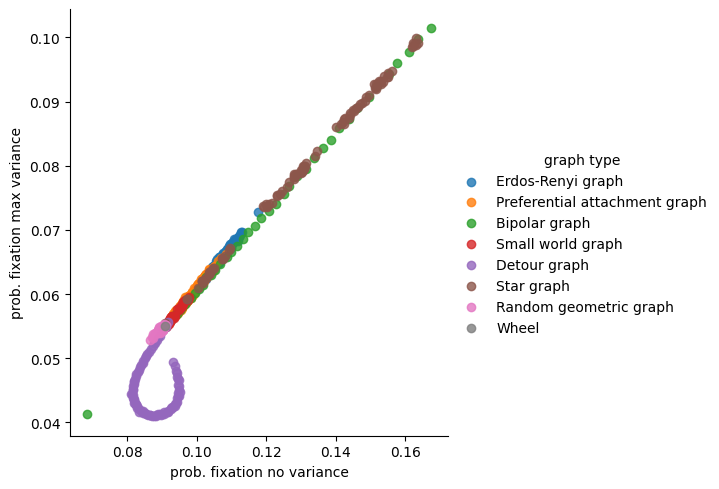

In [18]:
plot_ratio_dir("graphs/rslt_param_graphs",save=True)

In [21]:
def plot_dir_among_all_graphs(namelist):
  x, y = np.load("xs.npy"), np.load("ys.npy")
  n0 = len(x)
  groups = np.vectorize(get_param_graph_label)(np.arange(0,n0))
  groups = np.where((groups == 'Erdos-Renyi graph') | (groups == 'Random geometric graph'), 'Random graphs', groups)
  fig, ax = plt.subplots()
  for g in np.unique(groups):
    ix = np.where(groups == g)
    ax.scatter(x[ix], y[ix], label = g,s=5)
  for name in namelist:
    dirname = f"./graphs/{name}/"
    result_dirname = f"./graphs/res_{name}"
    n = len(os.listdir(f"{result_dirname}1"))
    xs = np.zeros((n,))
    ys = np.zeros((n,))
    for rep in range(1,6):
      result_dir = f"{result_dirname}{rep}"
      for filename in os.listdir(result_dir):
        f = (os.path.join(result_dir,filename))
        id = int(filename.split(".")[0])
        if os.stat(f).st_size == 0:
          print(id, "file is empty")
        data = pd.read_csv(f, sep='\t', header=None)
        xs[id%n] += (data.iloc[0,4])
        ys[id%n] += (data.iloc[1,4])
    ax.scatter(xs/(5), ys / (5), label = name,s=5)
  plt.gca().set(title="", xlabel="prob. fixation no variance", ylabel="prob. fixation with variance = 0.9")
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.show()

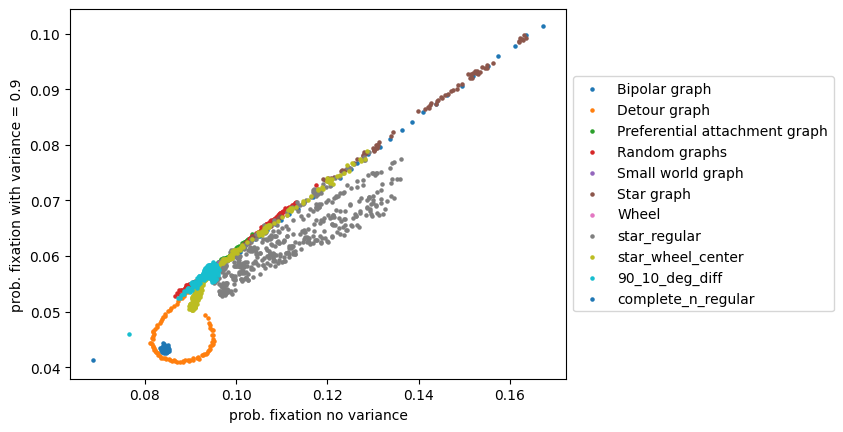

In [22]:
dirlist = ["star_regular","star_wheel_center","90_10_deg_diff","complete_n_regular"] 
## can have better color labeling (at least distinguish )
plot_dir_among_all_graphs(dirlist)

### Figure 3
idea: robustness - how does graph size affect pfix or S_eff
think i have it for wellmixed and regular, can have it for star too

In [106]:
def fx(x, pfix):
  '''return pfix - (1-(1+S_eff)^{-1}) / (1-(1+S_eff)^{-N})
     solving for x = S_eff
  '''
  term = (1 - 1/(1 + x)) / (1 - 1 / ((1 + x) ** 100))
  return pfix-term

def plot_largeN(result_dirname, type="line"):
  if type=="seff":
    mod = 19
    start = np.array([0.01])
    xs = np.zeros((mod,))
    ys = np.zeros((mod,))
    count = np.zeros((mod,))
    for rep in range(1,6):
      result_dir = f"{result_dirname}{rep}"
      for filename in os.listdir(result_dir):
        f = (os.path.join(result_dir,filename))
        id = int(filename.split(".")[0])
        if os.stat(f).st_size == 0:
          print(id, rep, "file is empty")
          continue
        data = pd.read_csv(f, sep='\t', header=None)
        xs[id%mod] += (data.iloc[0,4])
        ys[id%mod] += (data.iloc[1,4])
        count[id%mod] += 1
    xs = xs/count
    ys = ys/count
    seff = np.zeros((mod,))
    for i in range(mod):
      seff[i] = scipy.optimize.fsolve(fx, x0=start, args=(ys[i]))
    plt.scatter([(i+1)*50 for i in range(mod)],seff)
    plt.xlabel("population size")
    plt.ylabel("s effective")
    plt.show()

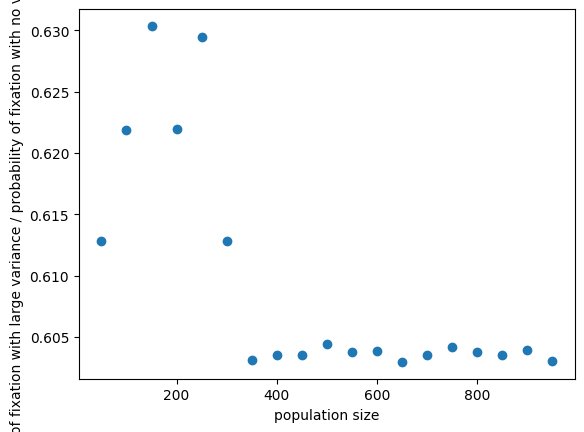

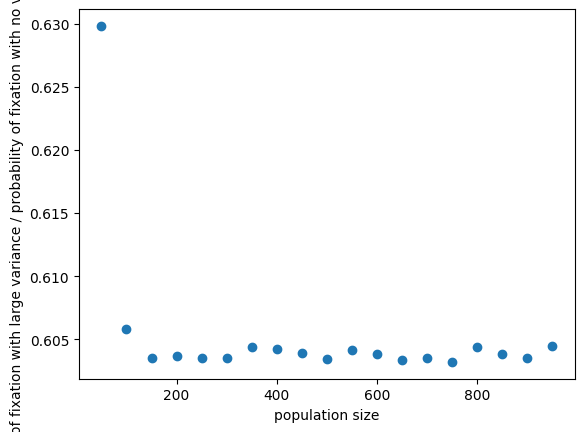

In [8]:
plot_largeN("graphs/res_largeN_regular",type="line")
plot_largeN("graphs/res_largeN_wellmixed",type="line")

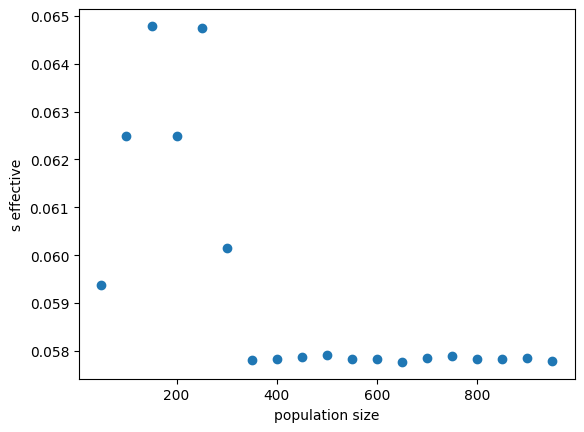

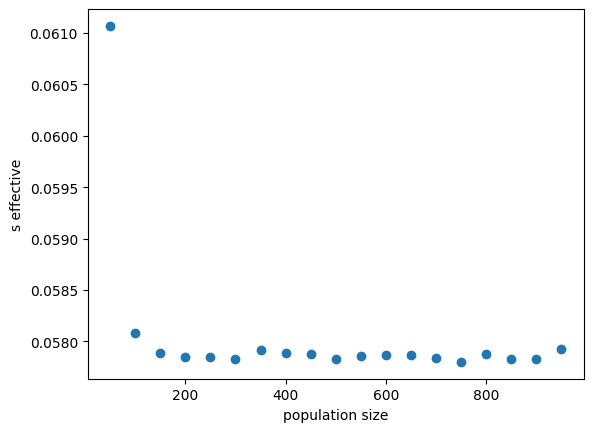

In [107]:
plot_largeN("graphs/res_largeN_regular",type="seff")
plot_largeN("graphs/res_largeN_wellmixed",type="seff")

### Figure 4
idea: line of pfix_max against pfix_zero when starting with +1 or -1 variant

### Figure 5
idea: how different graph topology affect pfix
plots to include:
- number of bottolenecks
- graph heterogeneity
- length of detour
- 1 detour vs. many

### Figure 6
the many colorful donuts one
YP thinks I need to think of better way to plot it such that we can see both separation and trend

In [92]:
def plot_detours(result_dirname, xaxis="",yaxis=""):
  n = 1101
  var_list = [0.0,.1,.2,.3,.4,.5,.6,.7,.8,.9]
  colors = np.zeros((n*10,))
  xs = np.zeros((n*10,))
  ys = np.zeros((n*10,))
  count = np.zeros((n*10,))
  # idx = np.zeros((n*10,))
  for rep in range(1,6):
    result_dir = f"{result_dirname}{rep}"
    # print(result_dir)
    for id in range(510,600):
    # for filename in glob.glob(result_dir+'/*out.txt'):
      filename = result_dir + f"/{id}out.txt"
      if not os.path.isfile(filename) or os.stat(filename).st_size == 0:
        print(id, "file is empty")
        continue
      data = pd.read_csv(filename, sep='\t', header=None)
      # zs[id%n] += (data.iloc[0,4])
      for i in range(10):
        var = var_list[i]
        colors[id*10 + i] = var
        xs[id*10 + i] += (data.iloc[0,4])
        ys[id*10 + i] += (data.iloc[i,4])  # ratio w variance
        count[id*10+i] += 1
        # idx[id*10+i] = id
  
  xs = xs/count
  ys = ys/count
  mask= np.isfinite(xs/ys)
  
  df = pd.DataFrame({xaxis:xs,yaxis:ys,"variance":colors})
  print(df.dropna())
  g = sns.lmplot(x=xaxis, y=yaxis, data=df, hue="variance",fit_reg=False)

/var/folders/lq/089n6f4x2zs22kswz64jkc2c0000gn/T/ipykernel_24953/239607749.py:28: RuntimeWarning: invalid value encountered in divide
  xs = xs/count
/var/folders/lq/089n6f4x2zs22kswz64jkc2c0000gn/T/ipykernel_24953/239607749.py:29: RuntimeWarning: invalid value encountered in divide
  ys = ys/count


      prob. fixation no variance  prob. fixation variance=0.9  variance
5100                    0.092135                     0.092135       0.0
5101                    0.092135                     0.091186       0.1
5102                    0.092135                     0.089245       0.2
5103                    0.092135                     0.086522       0.3
5104                    0.092135                     0.081958       0.4
...                          ...                          ...       ...
5995                    0.093270                     0.076591       0.5
5996                    0.093270                     0.069905       0.6
5997                    0.093270                     0.063336       0.7
5998                    0.093270                     0.056763       0.8
5999                    0.093270                     0.049259       0.9

[900 rows x 3 columns]


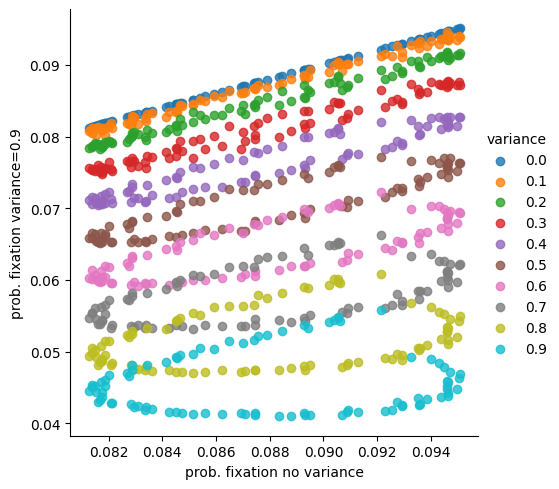

In [93]:
result_dirname = "graphs/rslt1_param_graphs"
plot_detours(result_dirname, "prob. fixation no variance", "prob. fixation variance=0.9")

/var/folders/lq/089n6f4x2zs22kswz64jkc2c0000gn/T/ipykernel_24953/2124584750.py:23: RuntimeWarning: invalid value encountered in divide
  xs = xs/count
/var/folders/lq/089n6f4x2zs22kswz64jkc2c0000gn/T/ipykernel_24953/2124584750.py:24: RuntimeWarning: invalid value encountered in divide
  ys = ys/count


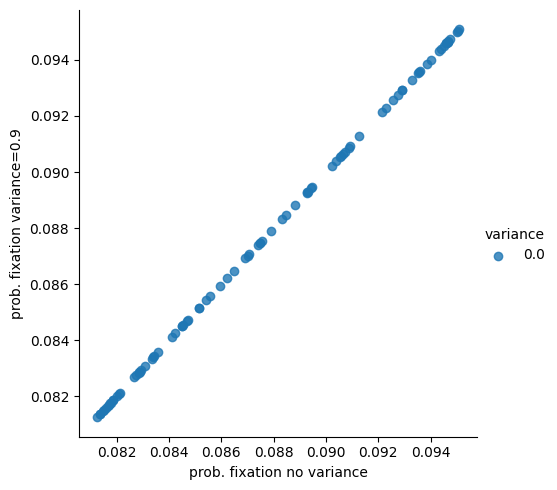

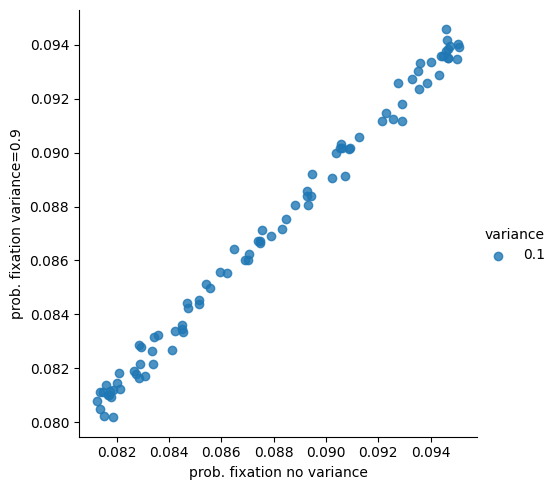

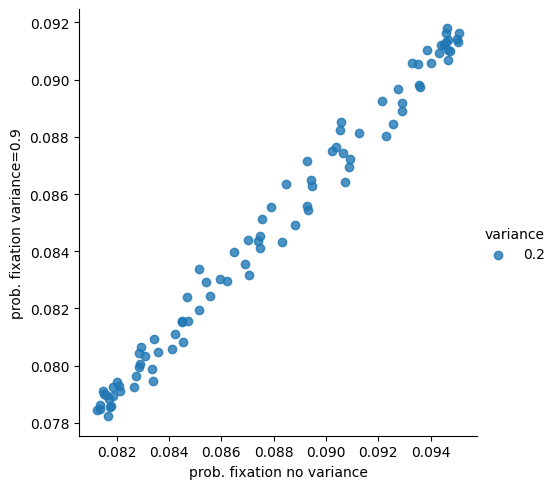

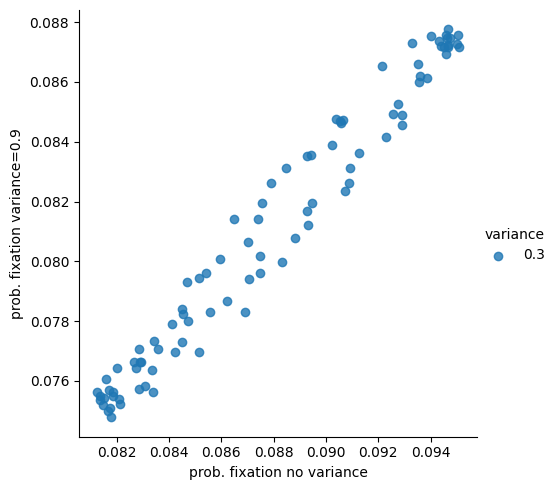

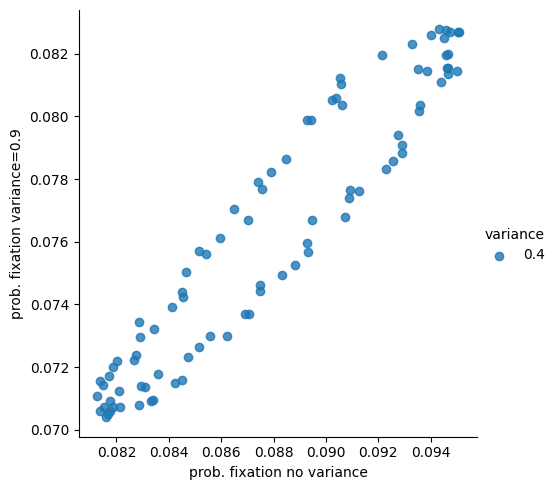

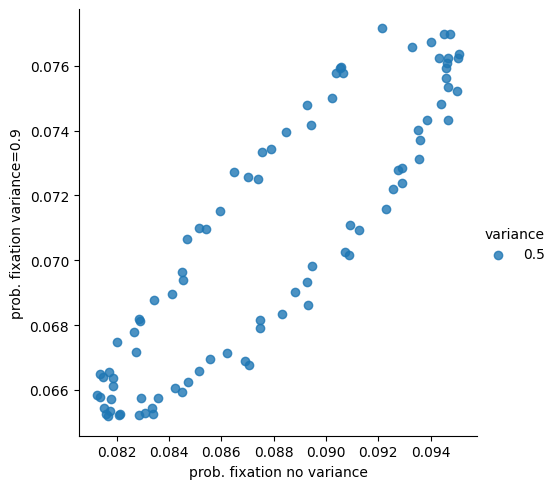

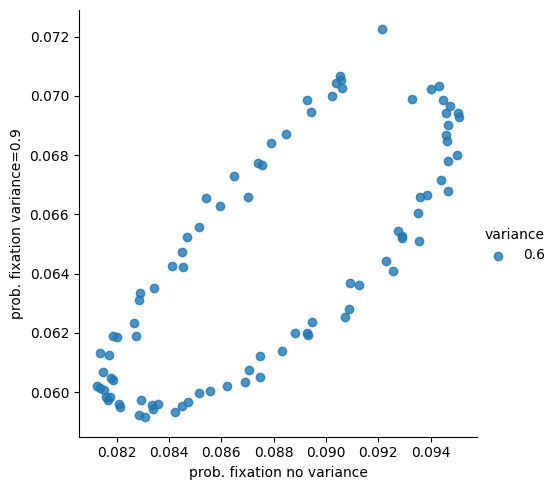

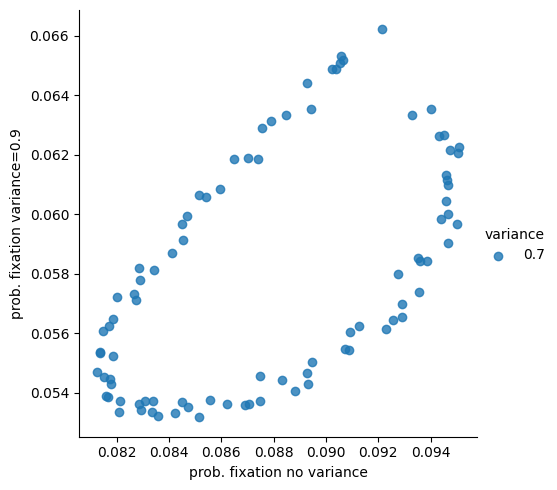

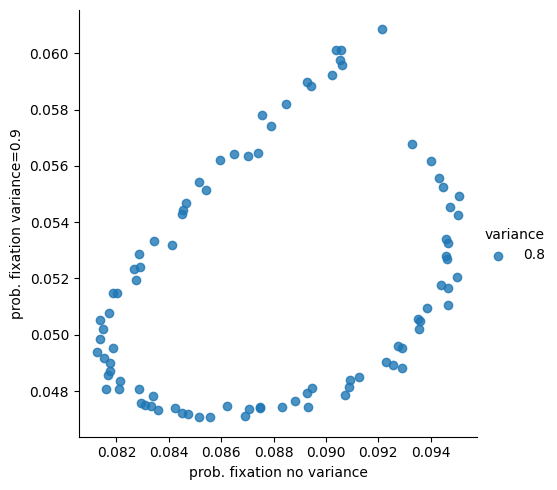

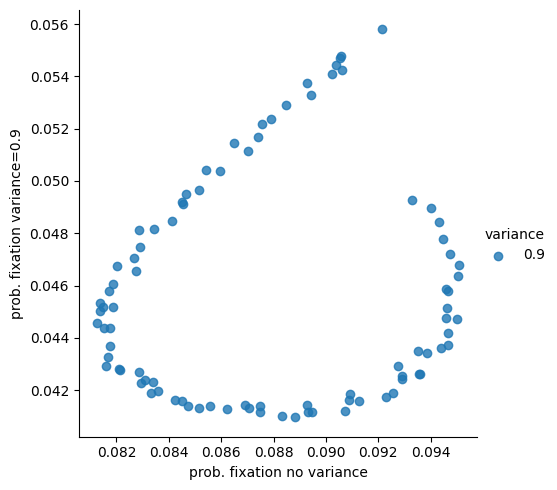

In [99]:
n = 1101
xaxis,yaxis="prob. fixation no variance", "prob. fixation variance=0.9"
var_list = [0.0,.1,.2,.3,.4,.5,.6,.7,.8,.9]
colors = np.zeros((n*10,))
xs = np.zeros((n*10,))
ys = np.zeros((n*10,))
count = np.zeros((n*10,))
result_dirname="graphs/rslt1_param_graphs"
for rep in range(1,6):
  result_dir = f"{result_dirname}{rep}"
  for id in range(510,600):
    filename = result_dir + f"/{id}out.txt"
    if not os.path.isfile(filename) or os.stat(filename).st_size == 0:
      print(id, "file is empty")
      continue
    data = pd.read_csv(filename, sep='\t', header=None)
    for i in range(10):
      var = var_list[i]
      colors[id*10 + i] = var
      xs[id*10 + i] += (data.iloc[0,4])
      ys[id*10 + i] += (data.iloc[i,4])  # ratio w variance
      count[id*10+i] += 1
xs = xs/count
ys = ys/count
mask= np.isfinite(xs/ys)
df = pd.DataFrame({xaxis:xs,yaxis:ys,"variance":colors})
df = (df.dropna())
# print(df)
# g = sns.FacetGrid(df, col="variance",col_wrap=10,sharey=True)
# g.map(sns.lmplot, x=xaxis, y=yaxis)
# g.axis[0].set_ylabel(yaxis)
# plt.subplots_adjust(wspace=0.1)
# plt.show()
for v in var_list:
  df_sub = df.loc[df['variance']==v]
  g = sns.lmplot(x=xaxis, y=yaxis, data=df_sub, hue="variance",fit_reg=False)
  plt.show()

### Figure 7
what Oana wants: see how different pfix_max affects the slope of the line and shape of donut :)
should be the same data as figure 6.

/var/folders/lq/089n6f4x2zs22kswz64jkc2c0000gn/T/ipykernel_24953/1802247012.py:24: RuntimeWarning: invalid value encountered in divide
  xs = xs/count
/var/folders/lq/089n6f4x2zs22kswz64jkc2c0000gn/T/ipykernel_24953/1802247012.py:25: RuntimeWarning: invalid value encountered in divide
  ys = ys/count


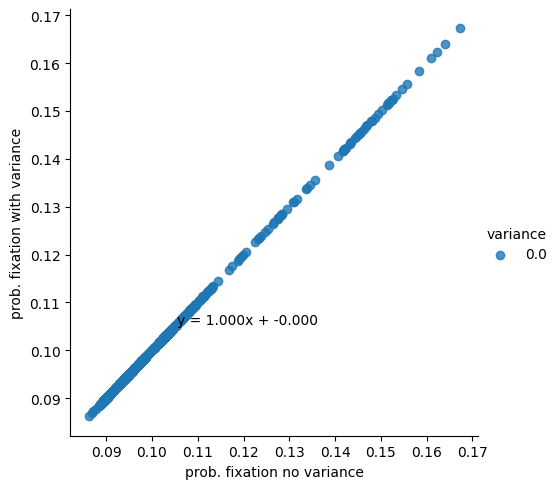

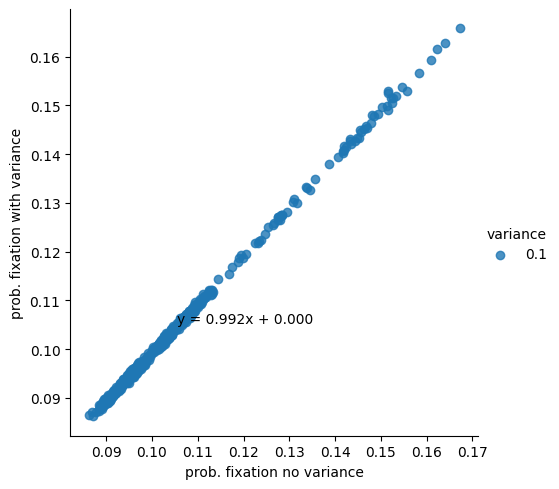

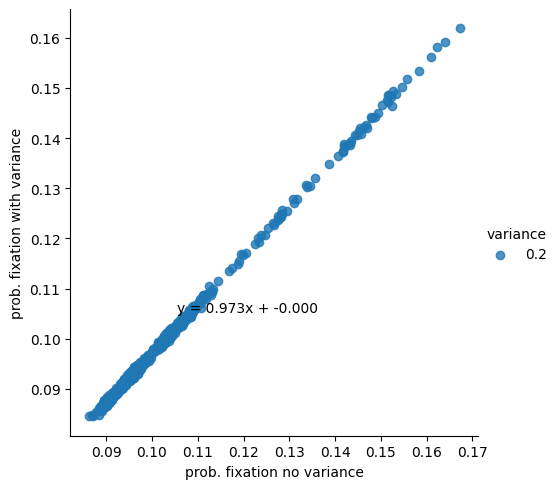

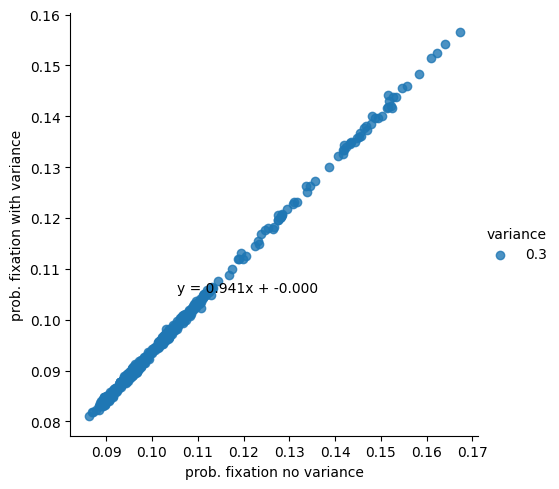

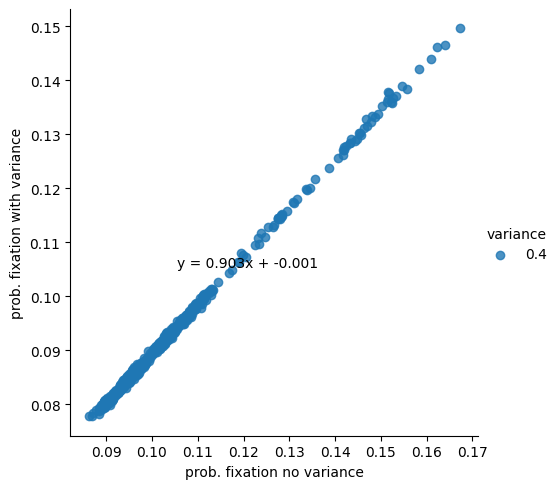

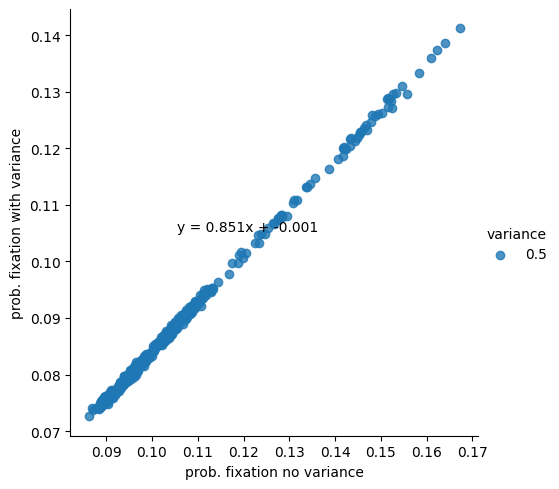

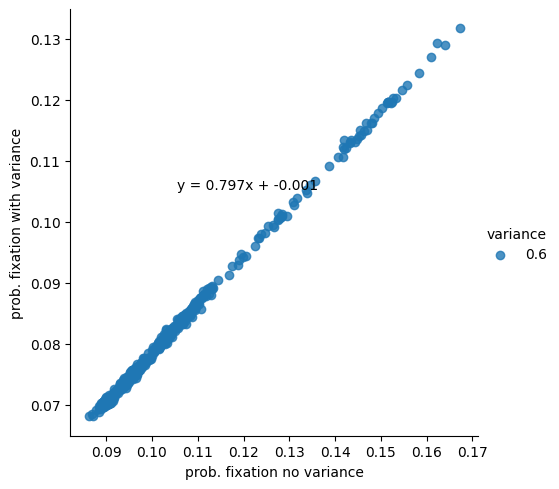

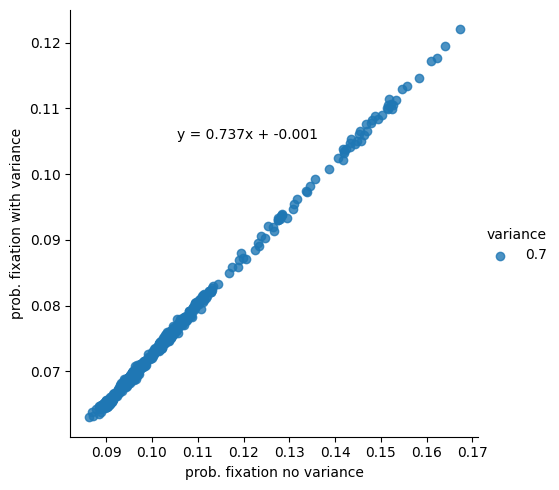

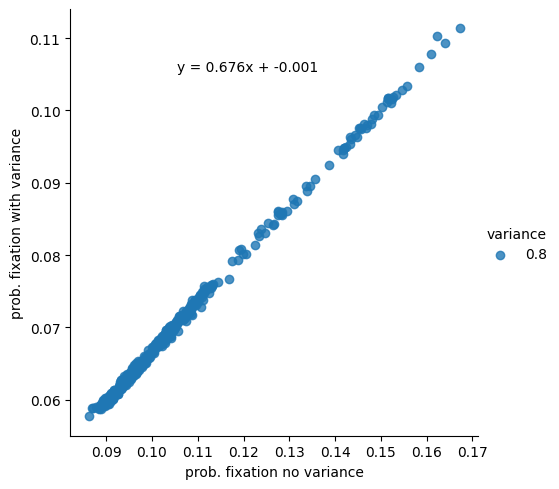

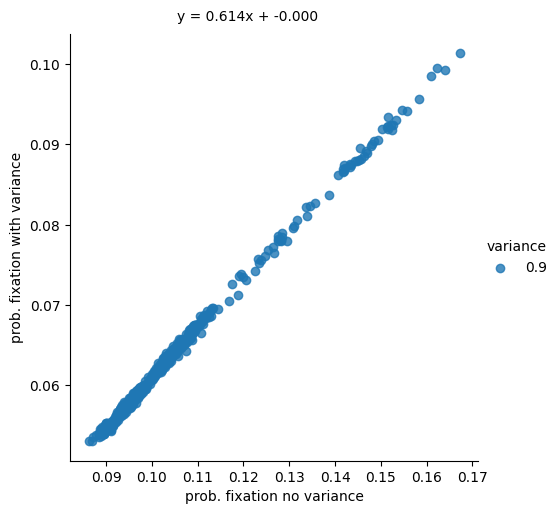

In [105]:
n = 1101
xaxis,yaxis="prob. fixation no variance", "prob. fixation with variance"
var_list = [0.0,.1,.2,.3,.4,.5,.6,.7,.8,.9]
colors = np.zeros((n*10,))
xs = np.zeros((n*10,))
ys = np.zeros((n*10,))
count = np.zeros((n*10,))
result_dirname="graphs/rslt1_param_graphs"
for rep in range(1,6):
  result_dir = f"{result_dirname}{rep}"
  for id in range(n):
    if 510 <= id < 600:continue
    filename = result_dir + f"/{id}out.txt"
    if not os.path.isfile(filename) or os.stat(filename).st_size == 0:
      # print(id, "file is empty")
      continue
    data = pd.read_csv(filename, sep='\t', header=None)
    for i in range(10):
      var = var_list[i]
      colors[id*10 + i] = var
      xs[id*10 + i] += (data.iloc[0,4])
      ys[id*10 + i] += (data.iloc[i,4])  # ratio w variance
      count[id*10+i] += 1
xs = xs/count
ys = ys/count
mask= np.isfinite(xs/ys)
df = pd.DataFrame({xaxis:xs,yaxis:ys,"variance":colors})
df = (df.dropna())

for v in var_list:
  df_sub = df.loc[df['variance']==v]
  g = sns.lmplot(x=xaxis, y=yaxis, data=df_sub, hue="variance",fit_reg=False)
  m,b = np.polyfit(df_sub[xaxis],df_sub[yaxis],1)
  plt.text(xs[0],ys[0], f"y = {m:.3f}x + {b:.3f}")
  plt.show()